In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from skimage.filters import threshold_otsu
from scipy.ndimage import shift
from scipy.signal import correlate
from skimage.filters import gaussian

from scipy.signal import convolve2d

In [ ]:
'''Help


# ---------------------------------------- Переменные -----------------------------------------------------------------
nx - ширина окна для автокорреляции зрачка, должно быть минимум в 2 раза больше, чем ширина зрачка [pix]
I0c - индикатор для зрачка  
f_scale - шаг по частоте, [м^-1]
delta - шаг апертуры или же просто размер 1ого пикселя, [м] 

def frequency_dim - создание пространства частот 
def c_jk - создание коэффициента передачи зрачка
def move_gamma - сдвиг гаммы относительно центра взависимости от скорости ветра
# ---------------------------------------------------------------------------------------------------------------------

Ex:

Для примера пусть Cn2 соответствует качеству изображения, равному 1 угловой секунде (типичное качество изображения) на длине 
волны 500 нм. Для удобства величину Cn2(z)dz рассматриваем как одну величину, обозначим ее C. Тогда:
    beta = 0.98 * lambda/r0 = 1, следовательно: r0 = 0.98*lambda*206265,
Пусть мы наблюдаем в зените, тогда параметр Фрида будет:
    r0 = (0.423*k^2 * C)^(-3/5), где k = 2*pi/lambda.
Далее можно просто выразить и посчитать С
    Cn2_ex = pow((0.98*lambda_)*206265, -5/3) / (0.423*pow(2*np.pi/lambda_, 2))
    
А вообще, нам неважно какое значение Cn2 брать, ответ всегда будет верным
# ---------------------------------------------------------------------------------------------------------------------

Подложки на изображении-результате кросс-корреляции быть не должно (ее видно если брать модуль от мнимой части). Видно, 
что значения мнимой части очень маленькие, поэтому можно выводить сразу действительную часть.
Черные области рядом с пиками - зоны Френеля. По радиусу этих зон можно посчитать дистанцию распространения
'''
print()

In [2]:
# --- апертурный фильтр
def aperture_func(nx, f_scale, delta): 
    fx, fy = f_scale * np.asarray(np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx)))
    res = np.abs(np.sinc(delta*fx)*np.sinc(delta*fy))**2
    res[np.isnan(res)] = 0
    return res
    
# --- модуль |f|^11/3 
def abs_f(nx, f_scale):
    fx, fy = f_scale * np.asarray(np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx)))
    with np.errstate(divide='ignore'):
        res = pow(np.sqrt(fx**2+fy**2), -11./3.)
    
    res[np.isnan(res)] = 0
    return res

# --- фильтр Френеля
def ffilter(nx, f_scale, z, lambda_): 
    fx, fy = f_scale * np.asarray(np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx)))
    res = pow(np.sin(np.pi*z*lambda_*(fx**2+fy**2)), 2) / pow(lambda_, 2)
    res[np.isnan(res)] = 0
    return res

# --- автокорреляция зрачка
def c_jk(nx, frame):
    I0c = (frame != 0) * int(1)
    res = correlate(I0c, I0c, mode='full', method='fft')
    res = res / np.sum(frame!=0)

    tmp = np.zeros((res.shape[0]+1, res.shape[1]+1))
    tmp[1:,1:] = res
    return tmp

# --- спектральный фильтр
def sfilter(nx, f_scale, z, D=None, resp_f=None):    
    # oversampling 
    coeff = 1000
    k = 1071*coeff
    lambda_max = int((len(resp_f)-1)*coeff)
    lambdas = np.linspace(0, lambda_max, k) * pow(10, -9) # [м]
    tail = np.zeros((len(lambdas) - len(resp_f)))
    resp_f = np.append(resp_f, tail)
    
    res_fft = pow((np.imag(np.fft.fft(resp_f/lambdas))), 2)

    delta_lambdas = (lambda_max / len(lambdas)) * pow(10, -9) # период дискретизации, шаг по частоте [м]
    omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]

    fx, fy = f_scale * np.asarray(np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx)))
    f_abs = np.sqrt(pow(fx, 2) + pow(fy, 2))

    omega = 0.5 * z * pow(f_abs, 2) # аргумент, шаг по частоте, [м^-1]
    omega = np.ravel(omega)
    omega_new = np.interp(omega, np.linspace(0, omega_lambdas_scale, k), res_fft)
    omega_new = np.resize(omega_new, (nx, nx))

    return omega_new

# --- монохроматическая гамма
def gamma_mono(Vx, Vy, Cn2, z, lambda_, frame=None, D=None, sec_per_frame=None, latency=None):
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2)
    nx=2*frame.shape[0]
    f_scale = 1/(2*D)
    delta = D/(frame.shape[0])

    t = sec_per_frame * latency
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta

    Fresnel_filter = ffilter(nx, f_scale, z, lambda_)
    f_11_3 = abs_f(nx, f_scale)
    A_f = aperture_func(nx, f_scale, delta) 
    
    with np.errstate(invalid='ignore'):
        res = f_11_3 * Fresnel_filter
    
    res[np.isnan(res)] = 0
    res = res * A_f
    res[np.isnan(res)] = 0
    
    res = np.fft.fftshift(np.fft.irfft2(np.fft.fftshift(res), s=res.shape, norm='backward'))
    res = res * 9.69*pow(10, -3)*16*pow(np.pi, 2)

    res = res * pow(f_scale*nx, 2)
    res = Cn2 * res   
    res = shift(res, (-Ypix, Xpix), order=1)
    
    cjk = c_jk(nx, frame)
    res = res * cjk
    return res

# --- полихроматическая гамма
def gamma_poly(Vx, Vy, Cn2, z, frame=None, D=None, sec_per_frame=None, latency=None, resp_f=None):
    nx=2*frame.shape[0]
    f_scale = 1/(2*D)
    delta = D/(frame.shape[0])

    t = sec_per_frame * latency
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
     
    Spectral_filter = sfilter(nx, f_scale, z, D=D, resp_f=resp_f)
    f_11_3 = abs_f(nx, f_scale) 
    A_f = aperture_func(nx, f_scale, delta) 
  
    with np.errstate(invalid='ignore'):
        res = f_11_3 * Spectral_filter
    
    res[np.isnan(res)] = 0
    res = res * A_f
    res[np.isnan(res)] = 0
    
    res = np.fft.fftshift(np.fft.irfft2(np.fft.fftshift(res), s=res.shape, norm='backward'))
    res = res * 9.69*pow(10, -3)*16*pow(np.pi, 2)

    res = res * pow(f_scale*nx, 2)
    res = Cn2 * res   
    res = shift(res, (-Ypix, Xpix), order=1)
    
    cjk = c_jk(nx, frame)
    res = res * cjk
    return res
 
# --- кросс-корреляция
def correlate1(frames, image_binary, latency): 
    def correlate_fft(img1, img2):
#         corr = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(img1)*np.fft.fft2(img2).conjugate()))) # np.real; np.abs
        corr = correlate(img1, img2, mode='full', method='fft')
        return corr

    correlation = [correlate_fft(frames[i], frames[i + latency]) for i in range(frames.shape[0] - latency)]
    res = np.mean(correlation, axis=0, dtype=np.float32)
    res /= np.sum(image_binary)
    
    tmp = np.zeros((res.shape[0]+1, res.shape[1]+1), dtype=np.float32)
    tmp[1:,1:] = res
    return tmp 
    
# --- получение чистого изображения зрачка
def pupil(images, latency): 
    def image_square_cropp(images): 
        mask = images[np.random.randint(images.shape[0])] != 0
        rows = np.flatnonzero((mask.any(axis=1))) 
        cols = np.flatnonzero((mask.any(axis=0)))
        res = images[:, rows.min():rows.max()+1, cols.min():cols.max()+1]
        return res    
    
    def image_size(image):
        if image.shape[1] != 226 or image.shape[2] != 226:
            tmp = np.zeros((image.shape[0], image.shape[1] - (image.shape[1] - 226), image.shape[2] - (image.shape[2] - 226)), 
                           dtype=np.float32)
            image = image[:, 0:image.shape[1] - (image.shape[1] - 226), 0:image.shape[2] - (image.shape[2] - 226)]
            if image.shape[1] < 226 and image.shape[2] == 226:
                tmp[:, (226-image.shape[1]):, :] = image
                return tmp
            if image.shape[2] < 226 and image.shape[1] == 226:
                tmp[:, :, (226-image.shape[2]):] = image
                return tmp
            else:
                return image
        else:
            return image
    
    image_average = np.mean(images, axis=0) # средний кадр серии
    
    image_binary = (image_average > threshold_otsu(image_average)*int(1)) # маска среднего кадра
    
    images_norm = [(i/(image_average))*(np.sum(image_average)/np.sum(i)) - 1 for i in images] # нормировка изображений
    images_clean = images_norm * image_binary # отделение зрачка от фона
    images_clean[np.isnan(images_clean)] = 0
      
    images_clean = image_square_cropp(images_clean) # обрезка зрачка в квадрат
    images_clean = image_size(images_clean) # подгонка размера изображений зрачка под 226х226
    
    cross_corr = correlate1(images_clean, image_binary, latency)
    res = images_clean[np.random.randint(images_clean.shape[0])]
    return res, cross_corr  

# --- считывание файлов
def run(file, file_bias=None, latency=None, data_dir=None):    
    st = time.perf_counter() 
    with fits.open(data_dir+'/'+file_bias) as f:
        f.info()
        bias = np.mean(f[0].data, axis=0, dtype=np.float32)
    
    with fits.open(data_dir+'/'+file) as f:
        f.info()
        header = f[0].header
#         if header['FRATE']:
#             sec_per_frame = 1 / f[0].header['FRATE']
#         else:
        sec_per_frame = 0.01
        data = np.float32(f[0].data)
        data -= bias
        frame, data_corr = pupil(data, latency)
  
    print('time:', time.perf_counter()-st)
    return frame, data_corr, sec_per_frame

Filename: D:/astro/domecam/bias20210130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 1000)   int16 (rescales to uint16)   
Filename: D:/astro/domecam/20210130f_0km.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 6000)   int16 (rescales to uint16)   
time: 100.75852249999997

pupil image shape: (224, 170)
cross corr image shape: (448, 340)
cross corr latency: 4
max cross corr value: (224, 170) 0.06437762
min cross corr value: (224, 172) -0.016676143


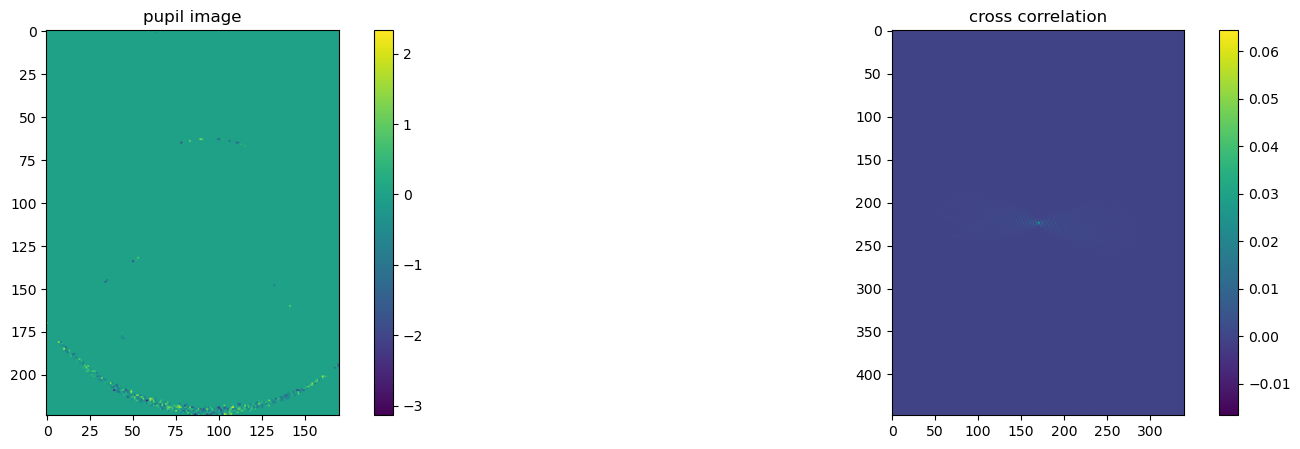

In [7]:
data_dir = 'D:/astro/domecam'
file = '20210130f_0km.fits'
file_bias = 'bias20210130.fits'  
resp_f = np.loadtxt(f"{data_dir}/resp_f.gz") 
latency = 4         
pupil_diameter = 2.5

frame, data_corr, sec_per_frame = run(file, file_bias=file_bias, latency=latency, data_dir=data_dir)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

fig.colorbar(ax.imshow(frame), ax = ax)
ax.set_title(f'pupil image')

fig.colorbar(ax2.imshow(data_corr), ax = ax2)
ax2.set_title(f'cross correlation')

print('')
print('pupil image shape:', frame.shape)
print('cross corr image shape:', data_corr.shape)
print('cross corr latency:', latency)
print('max cross corr value:', np.unravel_index(np.argmax(data_corr), data_corr.shape), np.max(data_corr))
print('min cross corr value:', np.unravel_index(np.argmin(data_corr), data_corr.shape), np.min(data_corr))

In [6]:
np.savetxt(f'{data_dir}/{file[:-5]}_corr_{latency}.gz', data_corr)
np.savetxt(f'{data_dir}/{file[:-5]}_corr_{latency}_blur.gz', gaussian(data_corr, sigma=1))

In [ ]:

tmp1 = gamma_poly(0, 0, 1.5e-13, 2000, 
                        frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency, resp_f=resp_f)
tmp2 = gaussian(tmp1, sigma=1)
tmp3 = gaussian(data_corr, sigma=1)

gammas = np.load(f'D:astro/domecam/gammas_blur.npy')

fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5)) 
fig.colorbar(ax.imshow(tmp1[196:256, 196:256]), ax=ax)
fig.colorbar(ax2.imshow(tmp2[196:256, 196:256]), ax=ax2)
fig.colorbar(ax3.imshow(data_corr), ax=ax3)
fig.colorbar(ax4.imshow(tmp3), ax=ax4)
ax.set_title('gamma, 2km')
ax2.set_title('gamma, 2km blur')
ax3.set_title('corr')
ax4.set_title('corr blur')


fig, (ax0, ax, ax2, ax3) = plt.subplots(1, 4, figsize=(25, 5)) 
fig.colorbar(ax0.imshow(gammas[4][196:256, 196:256]), ax=ax0)
fig.colorbar(ax.imshow((data_corr-tmp1)[196:256, 196:256]), ax=ax)
fig.colorbar(ax2.imshow((tmp3 - tmp2)[196:256, 196:256]), ax=ax2)
fig.colorbar(ax3.imshow((tmp3 - gammas[6])[196:256, 196:256]), ax=ax3)
ax0.set_title('loaded gamma, 2km blur')
ax.set_title('corr-gamma')
ax2.set_title('corr-blur gamma')
ax3.set_title('corr-blur loaded gamma')


np.savetxt(f'D:/astro/domecam/corr{latency}_blur.gz', tmp3)

In [ ]:
tmp1 = np.loadtxt(f'D:astro/domecam/corr4_blur.gz')
tmp2 = np.loadtxt(f'D:astro/domecam/corr4_orig.gz')

g_blur = np.load(f'D:astro/domecam/gammas_blur.npy')
g_orig = np.load(f'D:astro/domecam/gammas_orig.npy')

fig, ((ax, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(25, 15)) 

fig.colorbar(ax.imshow(tmp2[196:256, 196:256]), ax=ax)
fig.colorbar(ax1.imshow(tmp1[196:256, 196:256]), ax=ax1)

fig.colorbar(ax2.imshow(g_orig[40][196:256, 196:256]), ax=ax2)
fig.colorbar(ax3.imshow(g_blur[40][196:256, 196:256]), ax=ax3)


fig, (ax, ax1) = plt.subplots(1, 2, figsize=(25, 5)) 
ax.plot(g_orig[40][226], range(452))
ax1.plot(g_blur[40][226], range(452))

In [ ]:
a1 = np.linspace(0, 50000, 100)
np.savetxt('D:/astro/domecam/z.gz', a1)
print(a1[0], a1[-1])

gammas1 = np.ndarray(shape=(len(a1), 452, 452))
gammas2 = np.ndarray(shape=(len(a1), 452, 452))

for i in range(len(a1)):
    gammas1[i] = gamma_poly(0, 0, 1e-13, a1[i], 
                        frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency, resp_f=resp_f)
    gammas2[i] = gaussian(gammas1[i], sigma=1)
    
print('Done!')
np.save(f'D:/astro/domecam/gammas_orig.npy', gammas1)
np.save(f'D:/astro/domecam/gammas_blur.npy', gammas2)
print(gammas1.shape, gammas2.shape)

In [ ]:
print(np.var(frame))
mask = frame!=0
a = np.sum(frame!=0)

print(np.var(frame, where=(mask==1)))

res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(frame)*np.fft.fft2(frame).conjugate()))) # np.real; np.abs
res = res / a
#res = res / res.size

print(np.var(frame, where=(mask==1))*(a/frame.size))
print(np.max(res))


mono = gamma_mono(0, 0, 1e-13, 2000, 6.5e-7, frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency)
print(np.max(mono))

# вот это тоже интересный момент с проверкой значений. типа значение автокорреляции в 0 равно значению дисперсии зрачка
# без учета нулевых значений

# пс. это следует из формулы для автокорреляции, зануляя сдвиг, тогда получем величину дисперсии. а коэффициент нормировки, 
# который равен делению на размер зрачка как раз отвечает за определение мат. ожидания в формуле для дисперсии

In [ ]:
from scipy.stats import norm
import statistics

y = norm.pdf(range(1071), 650, 1)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax.plot(resp_f)
ax2.plot(y)

poly1 = gamma_poly(0, 0, 1e-13, 1994, 
                   frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency, resp_f=resp_f)
poly2 = gamma_poly(0, 0, 1e-13, 1994, 
                   frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency, resp_f=y)
mono = gamma_mono(0, 0, 1e-13, 1994, 6.5e-7,
                   frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency)


print(f'{np.max(poly1):.5f} {np.max(poly2):.5f} {np.max(mono):.5f} {0.0167601:.5f}')


# добавить в отчет табличку со сравнением этих значений, типа указать, что мы проверили все это

# а сами значения были получены путем численного подсчета интеграла, путем зануления j и k

In [ ]:
Vx=0
Vy=0

mono = gamma_mono(Vx, Vy, 2e-14, 5000, 8.5e-7,
                   frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency)
poly = gamma_poly(Vx, Vy, 2e-14, 5000, 
                   frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency, resp_f=resp_f)

fig, ((ax, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

fig.colorbar(ax.imshow(mono), ax = ax)
ax.set_title('mono')
ax3.plot(range(452), mono[226, :])

fig.colorbar(ax2.imshow(poly), ax = ax2)
ax2.set_title('poly')
ax4.plot(range(452), mono[226, :], label='mono')
ax4.plot(range(452), poly[226, :], color='red', ls='--', alpha=0.5, label='poly')
ax4.legend()

In [ ]:
# l1 = sfilter(452, 1/(2*pupil_diameter), 2000, D=pupil_diameter, resp_f=resp_f)

# fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# ax.plot(resp_f, color='black')
# ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
# ax.set_xlabel('λ, nm')
# ax.set_ylabel('F(λ)')

# fig.colorbar(ax2.imshow(l1, cmap='gray'), ax = ax2)
# x = np.round(np.linspace(-0.2, 0.2, 5), 2)
# ax2.set_xticks(np.linspace(0, 452, 5))
# ax2.set_yticks(np.linspace(0, 452, 5))
# ax2.set_xticklabels(x)
# ax2.set_yticklabels(x)
# ax2.set_xlabel('fx, 1e5 m^-1')
# ax2.set_ylabel('fy, 1e5 m^-1')

# fig.savefig('D:/astro/resp_f.png', bbox_inches='tight')

In [ ]:
# '''Отрисовка спеклов для отчета'''

# def draw_correlate_with_velocity(data, D, Dpix, latency, sec_per_frame): 
#     v = (D / Dpix) / (latency * sec_per_frame)
#     x = np.round(v*np.linspace(-data.shape[0]//2+1, data.shape[0]//2, 5), 2)
#     y = np.round(v*np.linspace(-data.shape[0]//2+1, data.shape[0]//2, 5), 2)
#     y = np.flipud(y)
#     fig = plt.figure()
#     ax = plt.axes()
#     im = plt.imshow(data, cmap='gray')
#     ax.set_xticks(np.linspace(0, data.shape[1], 5))
#     ax.set_yticks(np.linspace(0, data.shape[0], 5))
#     ax.set_xticklabels(x)
#     ax.set_yticklabels(y)
#     ax.set_ylabel('Vy, m/s')
#     ax.set_xlabel('Vx, m/s')
#     cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
#     plt.colorbar(im, cax=cax)
#     ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
#     fig.savefig('D:/astro/cross_corr_m2.png', bbox_inches='tight')

# draw_correlate_with_velocity(data_corr, pupil_diameter, frame.shape[0], latency, sec_per_frame)

In [ ]:
# fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

# poly = gamma_poly(Vx, Vy, 1.4094704893222763*1e-13, 2000, 
#                    frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency, resp_f=resp_f)

# print(np.max(data_corr)/np.max(poly))
# k=100
# new_corr = data_corr[226-k:226+k, 226-k:226+k]
# new_gamma = poly[226-k:226+k, 226-k:226+k]

# cmap='gray'
# fig.colorbar(ax.imshow(new_corr, cmap=cmap), ax = ax)

# fig.colorbar(ax2.imshow(new_gamma, cmap=cmap), ax = ax2)

# ax3.plot(new_corr[k, :], range(2*k), color='gray', label='original data')
# # ax3.plot(np.zeros((2*k,)), range(2*k), color='black')
# ax3.plot(new_gamma[k, :], range(2*k), ls='--', color='red', label='speckle model')
# ax3.grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.4)
# ax3.legend()

# fig.savefig('D:/astro/dome_corr.png', bbox_inches='tight')